# Session-based recommendation using word2vec
> How to build a session-based product recommender using word2vec model on retail dataset

- toc: true
- badges: true
- comments: true
- categories: [session, retail]
- image: 

### Install/import libraries

In [ ]:
# !sudo apt-get install -y ray
# !pip install ray
# !pip install ray[default]
# !pip install ray[tune]

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from numpy.random import default_rng
import collections
import itertools
from copy import deepcopy 

from gensim.models.word2vec import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
from ray import tune

import os
import argparse
import ray
import time

MODEL_DIR = "/content"

In [74]:
plt.style.use("seaborn-white")
cldr_colors = ['#00b6b5', '#f7955b','#6c8cc7', '#828282']#
cldr_green = '#a4d65d'
color_palette = "viridis"

rng = default_rng(123)

ECOMM_PATH = "/content"
ECOMM_FILENAME = "OnlineRetail.csv"

%load_ext tensorboard

### Load data

In [ ]:
!wget -O data.zip https://github.com/sparsh-ai/reco-data/blob/master/onlineretail.zip?raw=true
!unzip data.zip

In [13]:
def load_original_ecomm(pathname=ECOMM_PATH):
    df = pd.read_csv(os.path.join(pathname, ECOMM_FILENAME),
        encoding="ISO-8859-1",
        parse_dates=["InvoiceDate"],
    )
    return df

In [46]:
df = load_original_ecomm()
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [47]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

### Preprocess

There are some rows with missing information, so we'll filter those out. Since we want to define customer sessions, we'll use group by CustomerID field and filter out any customer entries that have fewer than three purchased items.

In [48]:
def preprocess_ecomm(df, min_session_count=3):

    df.dropna(inplace=True)
    item_counts = df.groupby(["CustomerID"]).count()["StockCode"]
    df = df[df["CustomerID"].isin(item_counts[item_counts >= min_session_count].index)].reset_index(drop=True)
    
    return df

In [57]:
df = preprocess_ecomm(df)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [58]:
# Number of unique customers after preprocessing
df.CustomerID.nunique()

4234

In [59]:
# Number of unique stock codes (products)
df.StockCode.nunique()

3684

### Product popularity
Here we plot the frequency by which each product is purchased (occurs in a transaction)

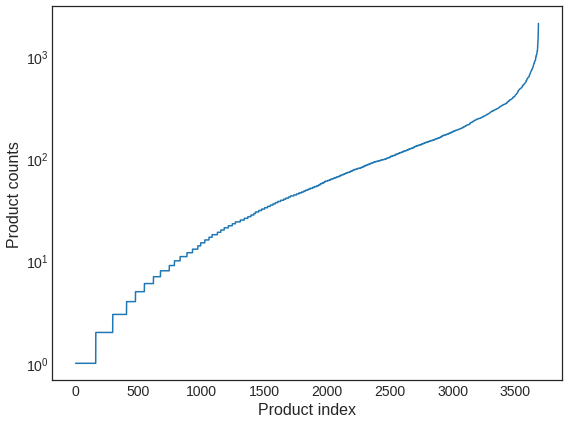

In [60]:
plt.style.use("seaborn-white")

# Number of unique customer IDs
product_counts = df.groupby(['StockCode']).count()['InvoiceNo'].values

fig = plt.figure(figsize=(8,6))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

plt.semilogy(sorted(product_counts))
plt.ylabel("Product counts", fontsize=16);
plt.xlabel("Product index", fontsize=16);

plt.tight_layout()

The left side of the figure corresponds to products that are not very popular (because they aren't purchased very often), while the far right side indicates that some products are extremely popular and have been purchased hundreds of times.

### Customer session lengths
We define a customer's "session" as all the products they purchased in each transaction, in the order in which they were purchased (ordered InvoiceDate). We can then examine statistics regarding the length of these sessions. Below is a boxplot of all customer session lengths.

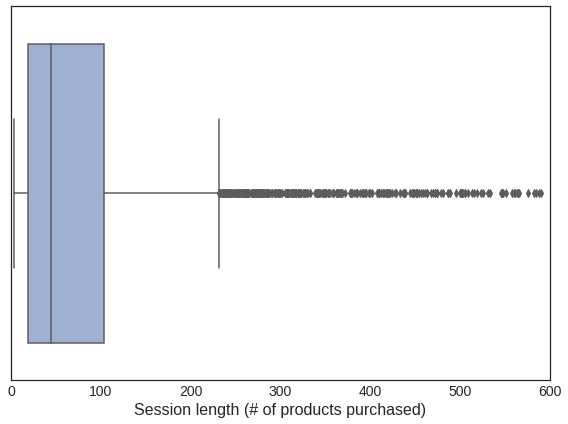

In [61]:
session_lengths = df.groupby("CustomerID").count()['InvoiceNo'].values

fig = plt.figure(figsize=(8,6))
plt.xticks(fontsize=14)

ax = sns.boxplot(x=session_lengths, color=cldr_colors[2])

for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .7))
    
plt.xlim(0,600)
plt.xlabel("Session length (# of products purchased)", fontsize=16);

plt.tight_layout()
plt.savefig("session_lengths.png", transparent=True, dpi=150)

In [62]:
print("Minimum session length: \t", min(session_lengths))
print("Maximum session length: \t", max(session_lengths))
print("Mean session length: \t \t", np.mean(session_lengths))
print("Median session length: \t \t", np.median(session_lengths))
print("Total number of purchases: \t", np.sum(session_lengths))

Minimum session length: 	 3
Maximum session length: 	 7983
Mean session length: 	 	 96.03967879074162
Median session length: 	 	 44.0
Total number of purchases: 	 406632


### Sessionization

In [56]:
def construct_session_sequences(df, sessionID, itemID, save_filename):
    """
    Given a dataset in pandas df format, construct a list of lists where each sublist
    represents the interactions relevant to a specific session, for each sessionID. 
    These sublists are composed of a series of itemIDs (str) and are the core training 
    data used in the Word2Vec algorithm. 
    This is performed by first grouping over the SessionID column, then casting to list
    each group's series of values in the ItemID column. 
    INPUTS
    ------------
    df:                 pandas dataframe
    sessionID: str      column name in the df that represents invididual sessions
    itemID: str         column name in the df that represents the items within a session
    save_filename: str  output filename 
  
    Example:
    Given a df that looks like 
    SessionID |   ItemID 
    ----------------------
        1     |     111
        1     |     123
        1     |     345
        2     |     045 
        2     |     334
        2     |     342
        2     |     8970
        2     |     345
    
    Retrun a list of lists like this: 
    sessions = [
            ['111', '123', '345'],
            ['045', '334', '342', '8970', '345'],
        ]
    """
    grp_by_session = df.groupby([sessionID])

    session_sequences = []
    for name, group in grp_by_session:
        session_sequences.append(list(group[itemID].values))

    pickle.dump(session_sequences, open(save_filename, "wb"))
    return session_sequences

In [63]:
filename = os.path.join(ECOMM_PATH, ECOMM_FILENAME.replace(".csv", "_sessions.pkl"))
sessions = construct_session_sequences(df, "CustomerID", "StockCode", save_filename=filename)
' --> '.join(sessions[0])

'85116 --> 22375 --> 71477 --> 22492 --> 22771 --> 22772 --> 22773 --> 22774 --> 22775 --> 22805 --> 22725 --> 22726 --> 22727 --> 22728 --> 22729 --> 22212 --> 85167B --> 21171 --> 22195 --> 84969 --> 84997C --> 84997B --> 84997D --> 22494 --> 22497 --> 85232D --> 21064 --> 21731 --> 84558A --> 20780 --> 20782 --> 84625A --> 84625C --> 85116 --> 20719 --> 22375 --> 22376 --> 20966 --> 22725 --> 22726 --> 22727 --> 22728 --> 22729 --> 22196 --> 84992 --> 84991 --> 21976 --> 22417 --> 47559B --> 21154 --> 21041 --> 21035 --> 22423 --> 84969 --> 22134 --> 21832 --> 22422 --> 22497 --> 21731 --> 84558A --> 22376 --> 22374 --> 22371 --> 22375 --> 20665 --> 23076 --> 21791 --> 22550 --> 23177 --> 22432 --> 22774 --> 22195 --> 22196 --> 21975 --> 21041 --> 22423 --> 22699 --> 21731 --> 22492 --> 84559A --> 84559B --> 16008 --> 22821 --> 22497 --> 23084 --> 23162 --> 23171 --> 23172 --> 23170 --> 23173 --> 23174 --> 23175 --> 22371 --> 22375 --> 85178 --> 17021 --> 23146 --> 22196 --> 84558A 

In [75]:
def load_ecomm(filename=None):
    """
    Checks to see if the processed Online Retail ecommerce session sequence file exists
        If True: loads and returns the session sequences
        If False: creates and returns the session sequences constructed from the original data file
    """
    original_filename = os.path.join(ECOMM_PATH, ECOMM_FILENAME)
    if filename is None:
        processed_filename = original_filename.replace(".csv", "_sessions.pkl")
        if os.path.exists(processed_filename):
            return pickle.load(open(processed_filename,'rb'))

    df = load_original_ecomm(original_filename)
    df = preprocess_ecomm(df)
    session_sequences = construct_session_sequences(df, "CustomerID", "StockCode",
                                                    save_filename=original_filename)
    return session_sequences

### Splitting

In [40]:
def train_test_split(session_sequences, test_size: int = 10000, rng=rng):
    """
    Next Event Prediction (NEP) does not necessarily follow the traditional train/test split. 
    Instead training is perform on the first n-1 items in a session sequence of n items. 
    The test set is constructed of (n-1, n) "query" pairs where the n-1 item is used to generate 
    recommendation predictions and it is checked whether the nth item is included in those recommendations. 
    Example:
        Given a session sequence ['045', '334', '342', '8970', '128']
        Training is done on ['045', '334', '342', '8970']
        Testing (and validation) is done on ['8970', '128']
    
    Test and Validation sets are constructed to be disjoint. 
    """

    ## Construct training set
    # use (1 st, ..., n-1 th) items from each session sequence to form the train set (drop last item)
    train = [sess[:-1] for sess in session_sequences]

    if test_size > len(train):
        print(
            f"Test set cannot be larger than train set. Train set contains {len(train)} sessions."
        )
        return

    ### Construct test and validation sets
    # sub-sample 10k sessions, and use (n-1 th, n th) pairs of items from session_squences to form the
    # disjoint validaton and test sets
    test_validation = [sess[-2:] for sess in session_sequences]
    index = np.random.choice(range(len(test_validation)), test_size * 2, replace=False)
    test = np.array(test_validation)[index[:test_size]].tolist()
    validation = np.array(test_validation)[index[test_size:]].tolist()

    return train, test, validation

In [42]:
print(len(sessions))
train, test, valid = train_test_split(sessions, test_size=1000)
print(len(train), len(valid), len(test))

4234
4234 1000 1000


### Metrics

In [64]:
def recall_at_k(test, embeddings, k: int = 10) -> float:
    """
    test must be a list of (query, ground truth) pairs
    embeddings must be a gensim.word2vec.wv thingy
    """
    ratk_score = 0
    for query_item, ground_truth in test:
        # get the k most similar items to the query item (computes cosine similarity)
        neighbors = embeddings.similar_by_vector(query_item, topn=k)
        # clean up the list
        recommendations = [item for item, score in neighbors]
        # check if ground truth is in the recommedations
        if ground_truth in recommendations:
            ratk_score += 1
    ratk_score /= len(test)
    return ratk_score


def recall_at_k_baseline(test, comatrix, k: int = 10) -> float:
    """
    test must be a list of (query, ground truth) pairs
    embeddings must be a gensim.word2vec.wv thingy
    """
    ratk_score = 0
    for query_item, ground_truth in test:
        # get the k most similar items to the query item (computes cosine similarity)
        try:
            co_occ = collections.Counter(comatrix[query_item])
            items_and_counts = co_occ.most_common(k)
            recommendations = [item for (item, counts) in items_and_counts]
            if ground_truth in recommendations: 
                ratk_score +=1
        except:
            pass
    ratk_score /= len(test)
    return ratk_score


def hitratio_at_k(test, embeddings, k: int = 10) -> float:
    """
    Implemented EXACTLY as was done in the Hyperparameters Matter paper. 
    In the paper this metric is described as 
        • Hit ratio at K (HR@K). It is equal to 1 if the test item appears
        in the list of k predicted items and 0 otherwise [13]. 
    
    But this is not what they implement, where they instead divide by k. 
    What they have actually implemented is more like Precision@k.
    However, Precision@k doesn't make a lot of sense in this context because
    there is only ONE possible correct answer in the list of generated 
    recommendations.  I don't think this is the best metric to use but 
    I'll keep it here for posterity. 
    test must be a list of (query, ground truth) pairs
    embeddings must be a gensim.word2vec.wv thingy
    """
    hratk_score = 0
    for query_item, ground_truth in test:
        # If the query item and next item are the same, prediction is automatically correct
        if query_item == ground_truth:
            hratk_score += 1 / k
        else:
            # get the k most similar items to the query item (computes cosine similarity)
            neighbors = embeddings.similar_by_vector(query_item, topn=k)
            # clean up the list
            recommendations = [item for item, score in neighbors]
            # check if ground truth is in the recommedations
            if ground_truth in recommendations:
                hratk_score += 1 / k
    hratk_score /= len(test)
    return hratk_score*1000


def mrr_at_k(test, embeddings, k: int) -> float:
    """
    Mean Reciprocal Rank. 
    test must be a list of (query, ground truth) pairs
    embeddings must be a gensim.word2vec.wv thingy
    """
    mrratk_score = 0
    for query_item, ground_truth in test:
        # get the k most similar items to the query item (computes cosine similarity)
        neighbors = embeddings.similar_by_vector(query_item, topn=k)
        # clean up the list
        recommendations = [item for item, score in neighbors]
        # check if ground truth is in the recommedations
        if ground_truth in recommendations:
            # identify where the item is in the list
            rank_idx = (
                np.argwhere(np.array(recommendations) == ground_truth)[0][0] + 1
            )
            # score higher-ranked ground truth higher than lower-ranked ground truth
            mrratk_score += 1 / rank_idx
    mrratk_score /= len(test)
    return mrratk_score


def mrr_at_k_baseline(test, comatrix, k: int = 10) -> float:
    """
    Mean Reciprocal Rank. 
    test must be a list of (query, ground truth) pairs
    embeddings must be a gensim.word2vec.wv thingy
    """
    mrratk_score = 0
    for query_item, ground_truth in test:
        # get the k most similar items to the query item (computes cosine similarity)
        try:
            co_occ = collections.Counter(comatrix[query_item])
            items_and_counts = co_occ.most_common(k)
            recommendations = [item for (item, counts) in items_and_counts]
            if ground_truth in recommendations: 
                rank_idx = (
                    np.argwhere(np.array(recommendations) == ground_truth)[0][0] + 1
                )
                mrratk_score += 1 / rank_idx
        except:
            pass
    mrratk_score /= len(test)
    return mrratk_score

### Baseline analysis

In [77]:
def association_rules_baseline(train_sessions):
    """
    Constructs a co-occurence matrix that counts how frequently each item 
    co-occurs with any other item in a given session. This matrix can 
    then be used to generate a list of recommendations according to the most
    frequently co-occurring items for the item in question. 

    These recommendations must be evaluated using the "_baseline"  recall/mrr functions in metrics.py
    """
    comatrix = collections.defaultdict(list)
    for session in train_sessions:
        for (x, y) in itertools.permutations(session, 2):
            comatrix[x].append(y)
    return comatrix

In [78]:
# Construct a co-occurrence matrix containing how frequently 
# each item is found in the same session as any other item
comatrix = association_rules_baseline(train)

# Recommendations are generated as the top K most frequently co-occurring items
# Compute metrics on these recommendations for each (query item, ground truth item)
# pair in the test set
recall_at_10 = recall_at_k_baseline(test, comatrix, k=10)
mrr_at_10 = mrr_at_k_baseline(test, comatrix, k=10)

print("Recall@10:", recall_at_10)
print("MRR@10:", mrr_at_10)

Recall@10: 0.143
MRR@10: 0.06450158730158734


### Initializing Ray

In [82]:
ray.init(num_cpus=4, ignore_reinit_error=True)

2021-06-11 06:21:17,485	INFO services.py:1274 -- View the Ray dashboard at http://127.0.0.1:8265


{'metrics_export_port': 42187,
 'node_id': '36950d392a77ab525dbcfe5ffdb2a3629ba8446f2aed261213be1f1f',
 'node_ip_address': '172.28.0.2',
 'object_store_address': '/tmp/ray/session_2021-06-11_06-21-14_124261_62/sockets/plasma_store',
 'raylet_ip_address': '172.28.0.2',
 'raylet_socket_name': '/tmp/ray/session_2021-06-11_06-21-14_124261_62/sockets/raylet',
 'redis_address': '172.28.0.2:6379',
 'session_dir': '/tmp/ray/session_2021-06-11_06-21-14_124261_62',
 'webui_url': '127.0.0.1:8265'}

### Train word2vec with logging

In [88]:
def train_w2v(train_data, params:dict, callbacks=None, model_name=None):
    if model_name: 
        # Load a model for additional training. 
        model = Word2Vec.load(model_name)
    else: 
        # train model
        if callbacks:
            model = Word2Vec(callbacks=callbacks, **params)
        else:
            model = Word2Vec(**params)
        model.build_vocab(train_data)

    model.train(train_data, total_examples=model.corpus_count, epochs=model.epochs, compute_loss=True)
    vectors = model.wv
    return vectors
    

def tune_w2v(config):
    ratk_logger = RecallAtKLogger(valid, k=config['k'], ray_tune=True)

    # remove keys from config that aren't hyperparameters of word2vec
    config.pop('dataset')
    config.pop('k')
    train_w2v(train, params=config, callbacks=[ratk_logger])


class RecallAtKLogger(CallbackAny2Vec):
    '''Report Recall@K at each epoch'''
    def __init__(self, validation_set, k, ray_tune=False, save_model=False):
        self.epoch = 0
        self.recall_scores = []
        self.validation = validation_set
        self.k = k
        self.tune = ray_tune
        self.save = save_model

    def on_epoch_begin(self, model):
        if not self.tune:
            print(f'Epoch: {self.epoch}', end='\t')

    def on_epoch_end(self, model):
        # method 1: deepcopy the model and set the model copy's wv to None
        mod = deepcopy(model)
        mod.wv.norms = None # will cause it recalculate norms? 
        
        # Every 10 epochs, save the model 
        if self.epoch%10 == 0 and self.save: 
            # method 2: save and reload the model
            model.save(f"{MODEL_DIR}w2v_{self.epoch}.model")
            #mod = Word2Vec.load(f"w2v_{self.epoch}.model")
        
        ratk_score = recall_at_k(self.validation, mod.wv, self.k)  

        if self.tune: 
            tune.report(recall_at_k = ratk_score)    
        else:
            self.recall_scores.append(ratk_score)
            print(f' Recall@10: {ratk_score}')
        self.epoch += 1


class LossLogger(CallbackAny2Vec):
    '''Report training loss at each epoch'''
    def __init__(self):
        self.epoch = 0
        self.previous_loss = 0
        self.training_loss = []

    def on_epoch_end(self, model):
        # the loss output by Word2Vec is more akin to a cumulative loss and increases each epoch
        # to get a value closer to loss per epoch, we subtract
        cumulative_loss = model.get_latest_training_loss()
        loss = cumulative_loss - self.previous_loss
        self.previous_loss = cumulative_loss
        self.training_loss.append(loss)
        print(f' Loss: {loss}')
        self.epoch += 1

In [ ]:
expt_dir = '/content/big_HPO_no_distributed'

Epoch: 0	 Recall@10: 0.181
 Loss: 731531.3125
Epoch: 1	 Recall@10: 0.209
 Loss: 619873.5625
Epoch: 2	 Recall@10: 0.213
 Loss: 511931.75
Epoch: 3	 Recall@10: 0.218
 Loss: 568087.625
Epoch: 4	 Recall@10: 0.216
 Loss: 587301.25


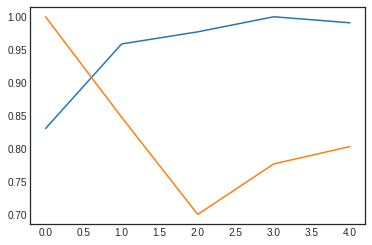

0.235
0.13457301587301593


In [87]:
use_saved_expt = False
if use_saved_expt:
  analysis = Analysis(expt_dir, default_metric="recall_at_k", default_mode="max")
  w2v_params = analysis.get_best_config()
else:
  w2v_params = {
          "min_count": 1,
          "iter": 5,
          "workers": 10,
          "sg": 1,
      }

# Instantiate callback to measurs Recall@K on the validation set after each epoch of training
ratk_logger = RecallAtKLogger(valid, k=10, save_model=True)
# Instantiate callback to compute Word2Vec's training loss on the training set after each epoch of training
loss_logger = LossLogger()
# Train Word2Vec model and retrieve trained embeddings
embeddings = train_w2v(train, w2v_params, [ratk_logger, loss_logger])

# Save results
pickle.dump(ratk_logger.recall_scores, open(os.path.join("/content", f"recall@k_per_epoch.pkl"), "wb"))
pickle.dump(loss_logger.training_loss, open(os.path.join("/content", f"trainloss_per_epoch.pkl"), "wb"))

# Save trained embeddings
embeddings.save(os.path.join("/content", f"embeddings.wv"))

# Visualize metrics as a function of epoch
plt.plot(np.array(ratk_logger.recall_scores)/np.max(ratk_logger.recall_scores))
plt.plot(np.array(loss_logger.training_loss)/np.max(loss_logger.training_loss))
plt.show()

# Print results on the test set
print(recall_at_k(test, embeddings, k=10))
print(mrr_at_k(test, embeddings, k=10))

### Tune word2vec with ray

In [111]:
from ray.tune import Analysis
from ray.tune.schedulers import ASHAScheduler

# Define the hyperparameter search space for Word2Vec algorithm
search_space = {
    "dataset": "ecomm",
    "k": 10,
    "size": tune.grid_search(list(np.arange(10,106, 6))),
    "window": tune.grid_search(list(np.arange(1,22, 3))),
    "ns_exponent": tune.grid_search(list(np.arange(-1, 1.2, .2))),
    "alpha": tune.grid_search([0.001, 0.01, 0.1]),
    "negative": tune.grid_search(list(np.arange(1,22, 3))),
    "iter": 10,
    "min_count": 1,
    "workers": 6,
    "sg": 1,
}

use_asha = True
smoke_test = False

# The ASHA Scheduler will stop underperforming trials in a principled fashion
asha_scheduler = ASHAScheduler(max_t=100, grace_period=10) if use_asha else None

# Set the stopping critera -- use the smoke-test arg to test the system 
stopping_criteria = {"training_iteration": 1 if smoke_test else 9999}

# Perform hyperparamter sweep with Ray Tune
analysis = tune.run(
    tune_w2v,
    name=expt_dir,
    local_dir="ray_results",
    metric="recall_at_k",
    mode="max",
    scheduler=asha_scheduler,
    stop=stopping_criteria,
    num_samples=1,
    verbose=1,
    resources_per_trial={
        "cpu": 1,
        "gpu": 0
    },
    config=search_space,
)
print("Best hyperparameters found were: ", analysis.best_config)

2021-06-11 09:06:44,670	ERROR tune.py:545 -- Trials did not complete: [tune_w2v_a0670_00492, tune_w2v_a0670_00493, tune_w2v_a0670_00494, tune_w2v_a0670_00495, tune_w2v_a0670_00496, tune_w2v_a0670_00497, tune_w2v_a0670_00498, tune_w2v_a0670_00499, tune_w2v_a0670_00500, tune_w2v_a0670_00501, tune_w2v_a0670_00502, tune_w2v_a0670_00503, tune_w2v_a0670_00504, tune_w2v_a0670_00505, tune_w2v_a0670_00506, tune_w2v_a0670_00507, tune_w2v_a0670_00508, tune_w2v_a0670_00509, tune_w2v_a0670_00510, tune_w2v_a0670_00511]
2021-06-11 09:06:44,678	INFO tune.py:549 -- Total run time: 6750.68 seconds (6746.07 seconds for the tuning loop).
2021-06-11 09:06:44,680	WARNING tune.py:554 -- Experiment has been interrupted, but the most recent state was saved. You can continue running this experiment by passing `resume=True` to `tune.run()`


Best hyperparameters found were:  {'dataset': 'ecomm', 'k': 10, 'size': 16, 'window': 1, 'ns_exponent': 0.7999999999999996, 'alpha': 0.1, 'negative': 19, 'iter': 10, 'min_count': 1, 'workers': 6, 'sg': 1}


Ray Tune saves the results of each trial in the ray_results directory. Each time Ray Tune performs an HPO sweep, the results for that run are saved under a unique subdirectory. In this case, we named that subdirectory big_HPO_no_distributed. Ray Tune provides methods for interacting with these results, starting with the Analysis class that loads the results from each trial, including performance metrics as a function of training time and tons of metadata.

These results are stored as JSON but the Analysis class provides a nice wrapper for converting those results in a pandas dataframe.

### Explore the results of the full hyperparameter sweep
Next, we're going to look at how the Recall@10 score changes as a function of various hyperparameter configurations that we tuned over. We tuned over three hyperparameters: the context window size, negative sampling exponent, and the number of negative samples.

We want to look at the Recall@10 scores for all of these configurations but this is a 3-dimensional space and, as such, will be difficult to visualize. Instead, we'll "collapse" one dimension, while examining the other two. To do this, we aggregate the Recall@10 scores (taking the mean) along the "collapsed" dimension.

In [112]:
analysis = Analysis("big_HPO_no_distributed/", 
                    default_metric="recall_at_k",
                    default_mode="max")

results = analysis.dataframe()
results

,recall_at_k,time_this_iter_s,done,timesteps_total,episodes_total,training_iteration,experiment_id,date,timestamp,time_total_s,pid,hostname,node_ip,time_since_restore,timesteps_since_restore,iterations_since_restore,trial_id,config/alpha,config/dataset,config/iter,config/k,config/min_count,config/negative,config/ns_exponent,config/sg,config/size,config/window,config/workers,logdir
0,0.237,5.543207,False,NaN,NaN,10,1faab4240d3746cbb4c51569db069051,2021-06-11_08-49-15,1623401355,71.839448,45684,3b5d652723e6,172.28.0.2,71.839448,0,10,a0670_00419,0.100,ecomm,10,10,1,19,0.6,1,16.0,1.0,6,big_HPO_no_distributed/tune_w2v_a0670_00419_41...
1,0.203,4.436352,False,NaN,NaN,10,fe00d91e28cf49beb45a0f47b900d2ae,2021-06-11_07-54-42,1623398082,75.372504,22252,3b5d652723e6,172.28.0.2,75.372504,0,10,a0670_00187,0.010,ecomm,10,10,1,19,0.6,1,10.0,1.0,6,big_HPO_no_distributed/tune_w2v_a0670_00187_18...
2,0.036,10.416867,False,NaN,NaN,9,965436df76d64eb1badb38eceda07998,2021-06-11_08-42-17,1623400937,55.470819,43108,3b5d652723e6,172.28.0.2,55.470819,0,9,a0670_00393,0.001,ecomm,10,10,1,16,0.4,1,16.0,1.0,6,big_HPO_no_distributed/tune_w2v_a0670_00393_39...
3,0.236,5.960799,False,NaN,NaN,9,8a3090a631b447bd9fb9ee249ef02a30,2021-06-11_08-52-44,1623401564,54.629899,47286,3b5d652723e6,172.28.0.2,54.629899,0,9,a0670_00434,0.100,ecomm,10,10,1,13,0.8,1,16.0,1.0,6,big_HPO_no_distributed/tune_w2v_a0670_00434_43...
4,0.041,1.409388,True,NaN,NaN,10,cce93e60ce3a4ff4a0db54a8e47fa3d9,2021-06-11_08-06-00,1623398760,38.842165,27810,3b5d652723e6,172.28.0.2,38.842165,0,10,a0670_00241,0.010,ecomm,10,10,1,10,-1.0,1,16.0,1.0,6,big_HPO_no_distributed/tune_w2v_a0670_00241_24...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,0.023,5.446685,False,NaN,NaN,3,9f3c574035ac47ac850519bf18e37184,2021-06-11_09-01-30,1623402090,22.201976,51082,3b5d652723e6,172.28.0.2,22.201976,0,3,a0670_00471,0.001,ecomm,10,10,1,10,-1.0,1,22.0,1.0,6,big_HPO_no_distributed/tune_w2v_a0670_00471_47...
504,0.015,2.176694,True,NaN,NaN,10,e927f2c1c10e42908c4c5b26d8ba5b86,2021-06-11_08-17-32,1623399452,41.176507,33062,3b5d652723e6,172.28.0.2,41.176507,0,10,a0670_00294,0.001,ecomm,10,10,1,1,-0.4,1,16.0,1.0,6,big_HPO_no_distributed/tune_w2v_a0670_00294_29...
505,0.211,1.697303,False,NaN,NaN,9,de953f60dd084976b0a01b62918adea5,2021-06-11_08-33-35,1623400415,19.104989,39782,3b5d652723e6,172.28.0.2,19.104989,0,9,a0670_00359,0.100,ecomm,10,10,1,1,0.2,1,16.0,1.0,6,big_HPO_no_distributed/tune_w2v_a0670_00359_35...
506,0.024,1.774843,False,NaN,NaN,4,d60beb2097b64164acbcb80fa8580019,2021-06-11_07-14-48,1623395688,13.840040,3454,3b5d652723e6,172.28.0.2,13.840040,0,4,a0670_00003,0.001,ecomm,10,10,1,4,-1.0,1,10.0,1.0,6,big_HPO_no_distributed/tune_w2v_a0670_00003_3_...


The Analysis objects also has methods to quickly retrieve the best configuration found during the HPO sweep.



In [113]:
best_config = analysis.get_best_config()
best_config

{'alpha': 0.1,
 'dataset': 'ecomm',
 'iter': 10,
 'k': 10,
 'min_count': 1,
 'negative': 19,
 'ns_exponent': 0.7999999999999996,
 'sg': 1,
 'size': 16,
 'window': 1,
 'workers': 6}

While the results dataframe contains the final Recall@10 scores for each of the 539 trials, it's also nice to explore how those scores evolved as a function of training for any given trial. Again, the Analysis class delivers, providing the ability to access the full training results for any of the trials. Below we plot the Recall@10 score as a function of training epochs for the best configuration.

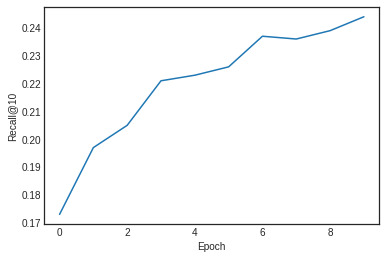

In [114]:
best_path = analysis.get_best_logdir()
dfs = analysis.fetch_trial_dataframes()

plt.plot(dfs[best_path]['recall_at_k']);
plt.xlabel("Epoch")
plt.ylabel("Recall@10");

In [116]:
def aggregate_z(x_name, y_name):
    grouped = results.groupby([f"config/{x_name}", f"config/{y_name}"])
    x_values = []
    y_values = []
    mean_recall_values = []
    
    for name, grp in grouped:
        x_values.append(name[0])
        y_values.append(name[1])
        mean_recall_values.append(grp['recall_at_k'].mean())
    return x_values, y_values, mean_recall_values

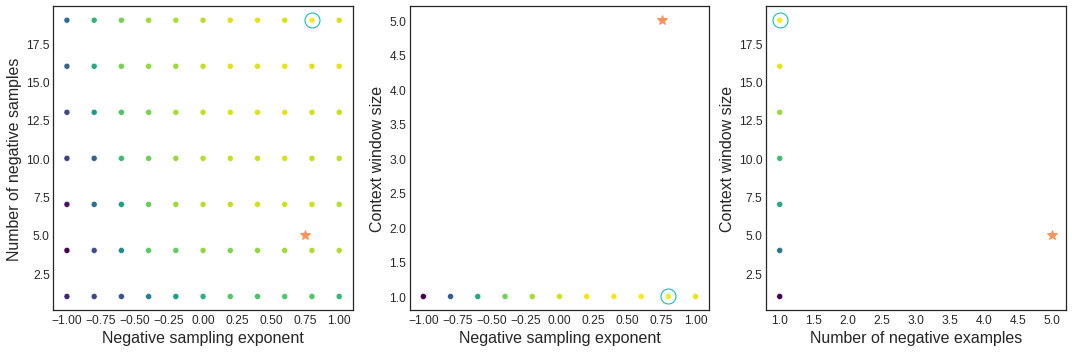

In [117]:
fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(131)
negative, ns_exp, recall = aggregate_z("negative", "ns_exponent")
cm = sns.scatterplot(x=ns_exp, y=negative, hue=recall, palette=color_palette, legend=None)
ax.set_xlabel("Negative sampling exponent", fontsize=16)
ax.set_ylabel("Number of negative samples", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.plot(0.75, 5, 
         marker='*', 
         color=cldr_colors[1],
         markersize=10)
ax.plot(best_config['ns_exponent'], 
        best_config['negative'], 
         marker="o", 
         fillstyle='none', 
         color=cldr_colors[0],
         markersize=15)
ax = fig.add_subplot(132)

window, ns_exp, recall = aggregate_z("window", "ns_exponent")
cm = sns.scatterplot(x=ns_exp, y=window, hue=recall, palette=color_palette, legend=None)
ax.set_xlabel("Negative sampling exponent", fontsize=16)
ax.set_ylabel("Context window size", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.plot(0.75, 5, 
           marker='*', 
           color=cldr_colors[1],
           markersize=10)
ax.plot(best_config['ns_exponent'], 
         best_config['window'], 
         marker="o", 
         fillstyle='none', 
         color=cldr_colors[0],
         markersize=15)

ax = fig.add_subplot(133)
window, negative, recall = aggregate_z("window", "negative")
cm = sns.scatterplot(x=window, y=negative, hue=recall, palette=color_palette, legend=None)
ax.set_xlabel("Number of negative examples", fontsize=16)
ax.set_ylabel("Context window size", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.plot(5, 5, 
        marker='*',
        color=cldr_colors[1],
        markersize=10)
ax.plot(best_config['window'], 
         best_config['negative'], 
         marker="o", 
         fillstyle='none', 
         color=cldr_colors[0],
         markersize=15);

plt.tight_layout()
plt.savefig("hpsweep_results.png", transparent=True, dpi=150)

And there we have it! Each panel shows the Recall@10 scores (where yellow is a high score and purple is a low score) associated with a unique configuration of hyperparameters. The best hyperparameter values for the Online Retail Data Set are denoted by the light blue circle. Word2vec’s default values are shown by the orange star. In all cases, the orange star is nowhere near the light blue circle, indicating that the default values are not optimal for this dataset.